# Contextualization
SIB(Small Industries Bank) loans money to companies in exchange for the promise of repayment. Given a number of metrics, we are to find whether a client for the bank will be defaulting on their loan or not.

# Loading imports and data:

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn.metrics as met
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Understanding the data

In [3]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


We have 12 different columns, after discounting the default status, with only 6 of them being purely numerical and one of them being the index which will not be used. We will require to categorize some of the features as well as create a few new ones

In [4]:
train.isnull().sum()

id                0
industry          1
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
default_status    0
dtype: int64

In [5]:
test.isnull().sum()

id                0
industry          0
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
dtype: int64

Only one record in the train set is empty or null, we will remove it from the data set altogether as it is not a significant portion of the records.

In [6]:
train = train.dropna()

In [7]:
train.isnull().sum()

id                0
industry          0
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
default_status    0
dtype: int64

In [8]:
train.default_status.value_counts()

0    1628
1     773
Name: default_status, dtype: int64

**id**: Is a non relevant factor and will be dropped later

**Industry**: We will start by analyzing if type of industry has any influence on probability of defaulting loan

,default_status
industry,
Trading,508
Construction,275
Consulting,267
Hotel,245
Manufacturing,245
Healthcare,219
Others,168
Administration,125
Transportation,106


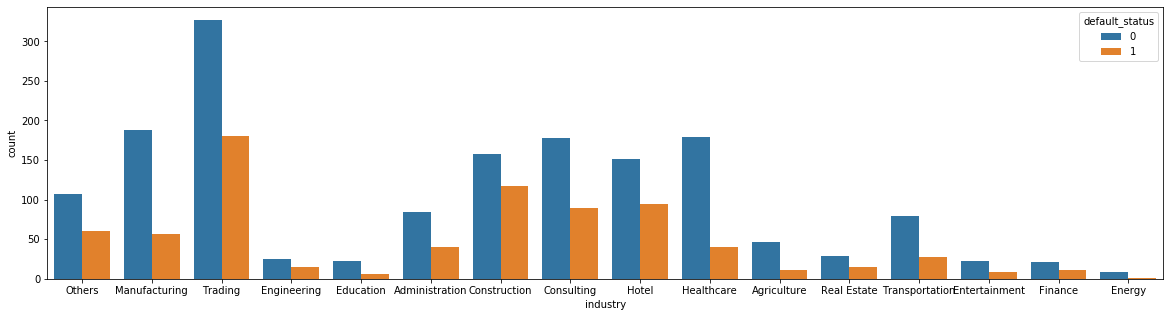

In [9]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="industry", hue="default_status", data=train)
train[['industry', 'default_status']].groupby(['industry']).count().sort_values(by='default_status', ascending=False)

,default_status
industry,
Construction,0.425455
Hotel,0.383673
Engineering,0.375000
Others,0.363095
Trading,0.356299
Finance,0.343750
Real Estate,0.340909
Consulting,0.333333
Administration,0.320000


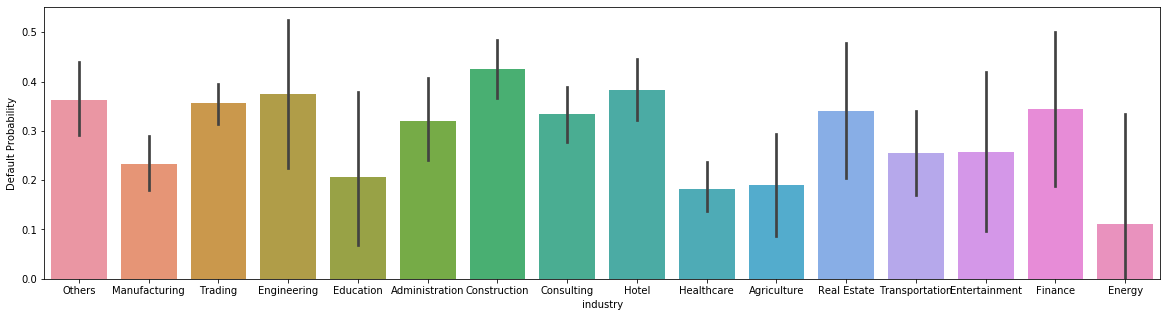

In [10]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="industry",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['industry', 'default_status']].groupby(['industry']).mean().sort_values(by='default_status', ascending=False)

None of the Industries show a particularly high rate of defaulting, however due to the low amount of data in some of them, their variance seems to be less stable, such as with Energy Industry. Values will be converted into numerical categories.

**State** More data that is not numerically categorized. If no pattern is identified from the different data, this feature will be considered for removal.

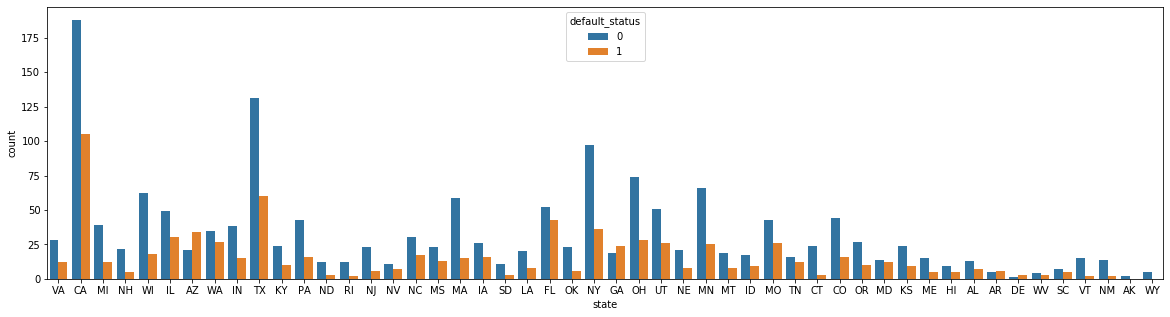

In [11]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="state", hue="default_status", data=train)


,default_status
state,
DE,0.750000
AZ,0.618182
GA,0.558140
AR,0.545455
MD,0.461538
FL,0.452632
WA,0.435484
WV,0.428571
TN,0.428571


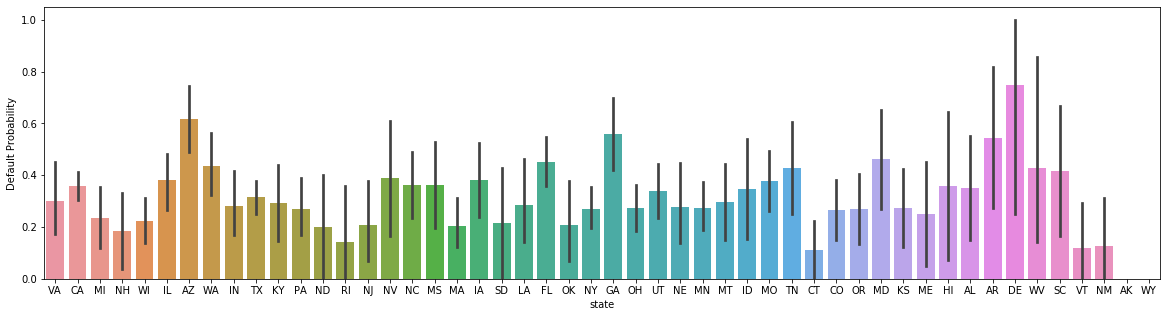

In [12]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="state",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['state', 'default_status']].groupby(['state']).mean().sort_values(by='default_status', ascending=False)

From the observed above, a higher chance to incur in a default is observed from states where the economy for small businesses are not as highly thriving as the more densely populated states. Such is the example of Denver, Arizona, Georgia and Arkansas. However in contrast to this, some of the states that have much more active economies for Small businesses such as California and Washington are close to split evenly in their chances of defaulting. As such this feature will be divided in 3 categories. High Risk with those states with a 50% chance or higher, Mid Risk with those between 21 and 49% risk and Low Risk/Slow Economy for those with 20% or less risk

**request date**: As a non discrete value, it needs to be discretized in a way that allows us to get insights into the data

In [13]:
train['request_date'] = pd.to_datetime(train['request_date'])

In [14]:
print(train.request_date.max())
print(train.request_date.min())

2010-09-30 00:00:00
2009-10-01 00:00:00


In [15]:
dates_train = train[['request_date', 'default_status']]
dates_train['month_year'] = pd.to_datetime(dates_train.request_date).dt.to_period('M')
dates_train = dates_train.sort_values(by=['month_year'])
dates_train.head()

D:\Miniconda3\envs\playground\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,request_date,default_status,month_year
946,2009-10-09,1,2009-10
1743,2009-10-29,0,2009-10
2022,2009-10-16,0,2009-10
2021,2009-10-14,0,2009-10
2013,2009-10-07,0,2009-10


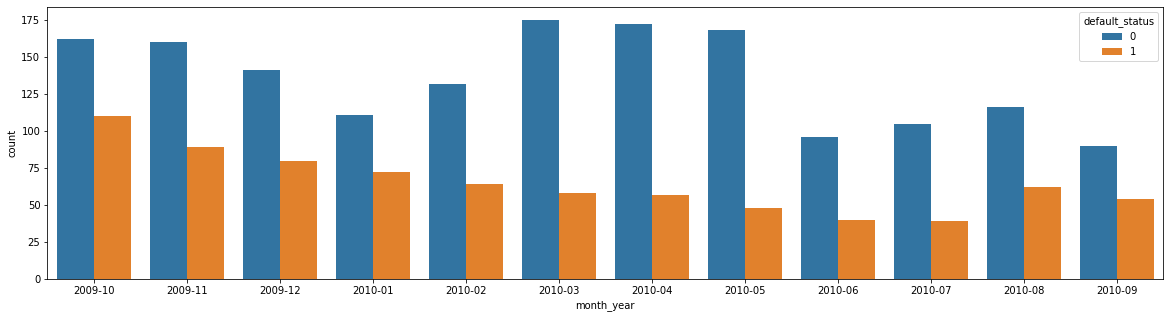

In [16]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="month_year", hue="default_status", data=dates_train)

With only 1 year of data and no previous historical records, it is not a significant factor in the analysis. This feature will be later dropped

**term**: We will observe the distribution of terms.

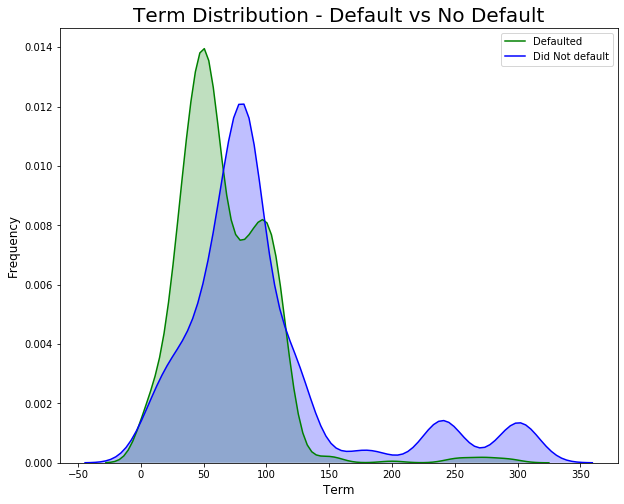

In [17]:
fig = plt.figure(figsize=(10,8),)
axis = sns.kdeplot(train.loc[(train['default_status'] == 1),'term'] , color='g',shade=True, label='Defaulted')
axis = sns.kdeplot(train.loc[(train['default_status'] == 0),'term'] , color='b',shade=True,label='Did Not default')
plt.title('Term Distribution - Default vs No Default', fontsize = 20)
plt.xlabel("Term", fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

Short term loans appear to be more likely to default. As such we will bin them in Short term, Mid term and Long term during feature engineering.

**employee count**: We will also analyse its distribution:

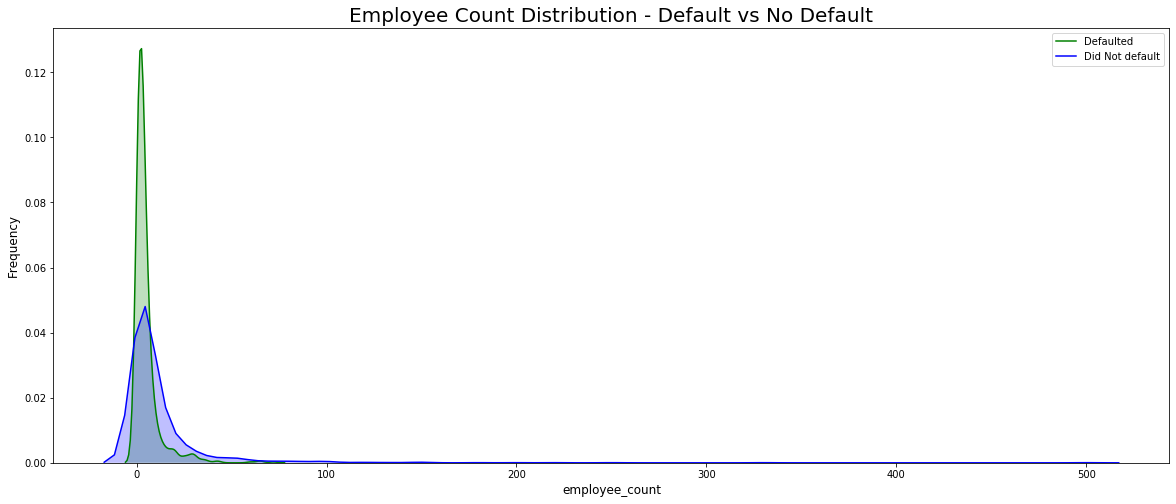

In [18]:
fig = plt.figure(figsize=(20,8),)
axis = sns.kdeplot(train.loc[(train['default_status'] == 1),'employee_count'] , color='g',shade=True, label='Defaulted')
axis = sns.kdeplot(train.loc[(train['default_status'] == 0),'employee_count'] , color='b',shade=True,label='Did Not default')
plt.title('Employee Count Distribution - Default vs No Default', fontsize = 20)
plt.xlabel("employee_count", fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

Companies with very few employees do appear to have more chance of defaulting, we will be analyzing this during feature transformation and deciding on dropping the feature or not.

**business new**: Text type data, will be converted to numerical and analyse its correlation during feature engineering

**business_type**: Only 2 different types of data, will leave as is

,default_status
business_type,
0,0.325253
1,0.265152


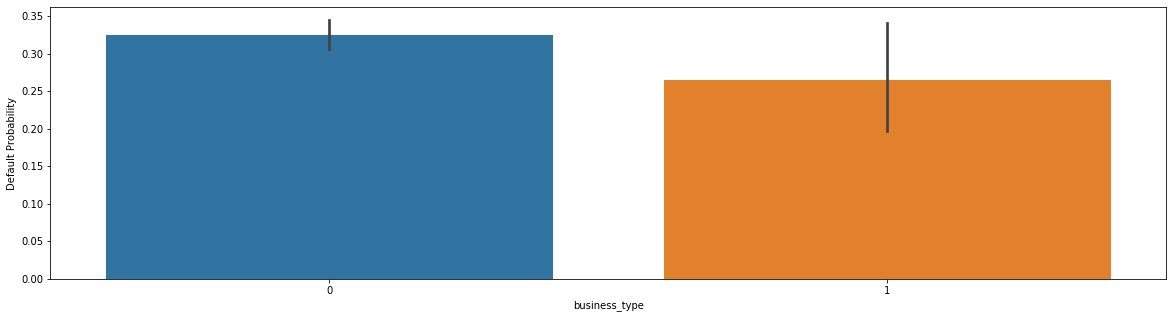

In [19]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="business_type",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['business_type', 'default_status']].groupby(['business_type']).mean().sort_values(by='default_status', ascending=False)

**Location**: All locations are rural, this feature will be deleted as it does not bring any usable insights

In [20]:
train.location.unique()

array(['Rural'], dtype=object)

**other loans, loan amount** and **insured amount** require processing before analysis of feature, to be done during feature engineering and potentially removing some of the features:

In [21]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,2010-04-27,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,2010-02-26,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,2010-06-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,2010-09-23,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


# Feature Engineering:

This is what will be done with the  respective features:

**id**: To be left as is

**Industry**: Get dummy values

**state**: To be removed

**request_date**: To be removed

**Term**: Create bins for feature, eliminate original

**employee count**: Analyse if bins have better performance, otherwise leave as is

**business new**: Transform to numerical

**business type**: Leave as is

**location**: Drop feature

**other loans**: Convert to numerical, check if relevant and delete if not

**loan amount**: Convert to numerical

**insured amount**: Conver to numerical, get uninsured amount from this and delete original feature


In [22]:
def common_cleanup(data):
    data['business_new'] = data['business_new'].replace('New', 1)
    data['business_new'] = data['business_new'].replace('Existing', 0)
    data['other_loans'] = data['other_loans'].replace('Y', 1)
    data['other_loans'] = data['other_loans'].replace('N', 0)
    data['loan_amount'] = data['loan_amount'].replace('[\$,]', '', regex=True).astype(float)
    data['insured_amount'] = data['insured_amount'].replace('[\$,]', '', regex=True).astype(float)
    data['uninsured_amount'] = data['loan_amount'] - data['insured_amount']
    data.drop(columns=['state','request_date','location'], inplace=True)

In [23]:
common_cleanup(train)
common_cleanup(test)

In [24]:
train = pd.get_dummies(train, columns = ["industry"])
test = pd.get_dummies(test, columns = ["industry"])

In [25]:
bins = [ 0, 60, 200, 500] 
term_index = (0,1,2)

train['term_bin'] = pd.cut(train.term, bins, labels=term_index).astype(int)
test['term_bin'] = pd.cut(test.term, bins, labels=term_index).astype(int)
train = train.drop(columns=['term'])
test = test.drop(columns=['term'])


In [26]:
train[['term_bin', 'default_status']].groupby(['term_bin'],as_index=False).mean()


,term_bin,default_status
0,0,0.458889
1,1,0.268908
2,2,0.041667


In [27]:
bins = [-1, 20, 200, 1000] 
term_index = (0,1,2)

train['employee_bin'] = pd.cut(train.employee_count, bins, labels=term_index)
test['employee_bin'] = pd.cut(test.employee_count, bins, labels=term_index)
train = train.drop(columns=['employee_count'])
test = test.drop(columns=['employee_count'])

In [28]:
train[['employee_bin', 'default_status']].groupby(['employee_bin'],as_index=False).mean()

,employee_bin,default_status
0,0,0.343822
1,1,0.127119
2,2,0.000000


In [29]:
train.head()

,id,business_new,business_type,other_loans,loan_amount,insured_amount,default_status,uninsured_amount,industry_Administration,industry_Agriculture,...,industry_Finance,industry_Healthcare,industry_Hotel,industry_Manufacturing,industry_Others,industry_Real Estate,industry_Trading,industry_Transportation,term_bin,employee_bin
0,4050975007,1,0,0,35000.0,35000.0,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,3735095001,1,0,0,15000.0,13500.0,1,1500.0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,3936555004,1,0,1,265000.0,100000.0,0,165000.0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,4130405000,1,0,0,255000.0,255000.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,4263615008,0,0,0,13300.0,6650.0,0,6650.0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating a Model:
First we will separate the target data from the training set and removing the id altogether. We will keep the ID for the test set as it will be used for the final results.

In [30]:
test_ids = test.id
test_data = test.drop(columns=['id'])
train_targets = train.default_status
train_data = train.drop(columns=['id', 'default_status'])


#x_train, x_test, y_train, y_test = train_test_split(train_data, train_targets, test_size=.2, random_state=4)

For the uneven data present, we will normalize all features:

In [31]:
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)
test_data_norm = scaler.transform(test_data)


For our training data, we divide in internal train and test in order to verify our performance

In [32]:
x_train, x_test, y_train, y_test = train_test_split(train_data_norm, train_targets, test_size=.2, random_state=4)

# Using Logistic Regression Model

In [44]:
logistic = LogisticRegression(penalty='l2', C=10, max_iter=100)
logistic.fit(x_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logistic.score(x_train, y_train)))
print("Test: {:6.2f}%".format(100*logistic.score(x_test, y_test)))
print("Loss: {:6.4f}".format(met.log_loss(y_test, logistic.predict_proba(x_test))))

The score for logistic regression is
Training:  71.88%
Validate:  70.89%
Log-loss: 0.5579


In [45]:
logistic_pred = logistic.predict(x_test)

accuracy = met.accuracy_score(y_test, logistic_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 70.8939708940%


# Using Random Forest Model

In [37]:
forest = RandomForestClassifier(n_estimators=100, max_depth=7, max_features=12)
forest.fit(x_train, y_train)
forest.score(x_train, y_train)

print("The score for Random Forest is")
print("Training: {:6.2f}%".format(100*forest.score(x_train, y_train)))
print("Validate: {:6.2f}%".format(100*forest.score(x_test, y_test)))
print("Log-loss: {:6.4f}".format(met.log_loss(y_test, forest.predict_proba(x_test))))

The score for Random Forest is
Training:  87.03%
Validate:  80.25%
Log-loss: 0.4479


In [38]:
forest_score = forest.fit(x_train, y_train).score(x_test, y_test)

In [40]:
forest_pred = forest.predict(x_test)

accuracy = met.accuracy_score(y_test, forest_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 79.6257796258%
